# Challenge: Machine Learning for Drone Identification
## David Gurevich

The identification of drones using sensors is an increasingly important problem in practice dueto the widespread availability of highly capable drones.  Radar is a long-range active sensor thatcan detect drones at longer ranges, as compared to optical sensors.  Therefore, it is of interest toinvestigate if radars can be used to identify drones.

In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

from scipy import signal, constants, fft
from sympy import *

%load_ext tensorboard

### 1: Implement Time-Domain Radar Return Signals from Drones

We begin by defining the function, $\phi(t)$. This function will take the following parameters:

$L_1$ -- (`L_1`) distance of the blade roots from the centre of rotation

$L_2$ -- (`L_2`) distance of the blade tips from the centre of rotation

$N$   -- (`N`) number of blades

$R$   -- (`R`) range of the centre of rotation

$V_\text{rad}$ -- (`V_rad`) radial velocity of the center of rotation with respect to the radar

$\theta$ -- (`theta`) angle between the plane of rotation and the line of sight from the radar to the center of rotation

$f_c$ -- (`fc`) transmitted frequency

$f_\text{rot}$ -- (`f_rot`) frequency of rotation

$t$ -- (`t`) time (linspace in Python)

We also define a scaling constant, $A$, that will remain 1 for now.

In [2]:
# Scaling constant
A = 1.0

def phi(L1, L2, N, R, V, theta, lmbda, f_rot, t):
    fc = constants.c / lmbda
    w_c = 2 * np.pi * fc
    w_r = 2 * np.pi * f_rot
    
    exp = lambda n : np.exp(1j * (w_c * t - (4*np.pi/lmbda) * (R + V*t + ((L1 + L2)/2) * np.cos(theta) * np.sin(w_r * t + 2*np.pi*n/N))))
    sinc = lambda n : np.sinc((4*np.pi/lmbda) * ((L2 - L1)/2) * np.cos(theta) * np.sin(w_r * t + 2 * np.pi * n / N))
    
    data = np.zeros(t.shape)
    for n in range (0, N):
        data += exp(n).real * sinc(n)
    
    return A * (L2 - L1) * data

Let's try this out on some "demo drone"

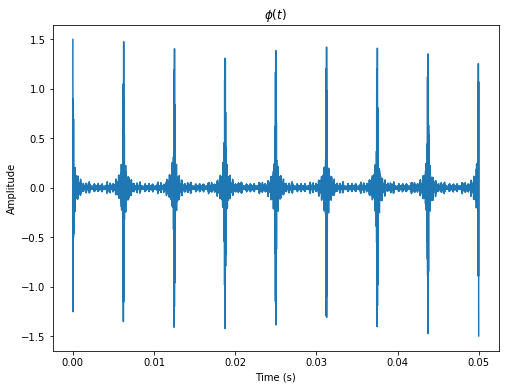

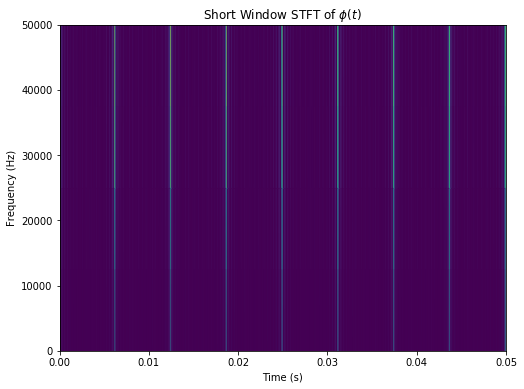

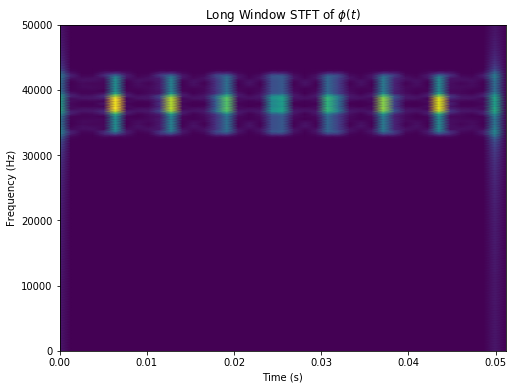

(5000,)
(255, 5000)


In [3]:
# Define Parameters
L_1 = 0.25
L_2 = 1
N = 4
R = 0
V_rad = 0
theta = 0
lmbda = 0.20
f_rot = 40
fs = 100000
dur = 0.05
t = np.linspace(0, dur, int(dur*fs))

data = phi(L_1, L_2, N, R, V_rad, theta, lmbda, f_rot, t)
#data = psi(t, lmbda, V_rad, L_1, L_2, theta, f_rot, N, 1)

plt.rcParams['figure.figsize'] = [8, 6]
plt.plot(t, data)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("$\phi(t)$")
plt.show()

f1, t1, Sxx1 = signal.stft(data, fs, nperseg=4, return_onesided=True)
plt.pcolormesh(t1, f1, np.abs(Sxx1), shading='gouraud')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Short Window STFT of $\phi(t)$")
plt.show()

f2, t2, Sxx2 = signal.stft(data, fs, nperseg=256, return_onesided=True)
plt.pcolormesh(t2, f2, np.abs(Sxx2), shading='gouraud')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Long Window STFT of $\phi(t)$")
plt.show()


coeffs, _ = pywt.cwt(data.real, range(1, 256), "morl")
print(data.shape)
print(coeffs.shape)

## 2: Simulate Radar Returns from Drones

The received radar signals from a drone is given by $\phi(t) + \mathbf{n}$, where $\mathbf{n}$ is random noise modelled by the Gaussian distribution with variance $\sigma^2$. The signal-to-noise ratio (SNR) is defined as $\left(\frac{A_r^2}{\sigma^2}\right)$, and the SNR in decibels is given by $10\log_{10} \left(\frac{A^2}{\sigma^2}\right)$

Here, I have chosen to model two hypothetical radars, one in X-Band (10 GHz), and the other in W-band (94 GHz)

In [4]:
x_band_radar = {}
x_band_radar['fc'] = 1 * 10**10
x_band_radar['lambda'] = constants.c / x_band_radar['fc']
x_band_radar['fs'] = int(1.5 * 10**4)

w_band_radar = {}
w_band_radar['fc'] = 9.4 * 10**10
w_band_radar['lambda'] = constants.c / w_band_radar['fc']
w_band_radar['fs'] = int(2.63 * 10**4)

Now, we write the function that generates our radar return

In [5]:
def radar_return(N, L2, f_rot, radar, SNR, t_offset):
    # N - number of blades
    # L2 - distance of blade tips from center of rotation
    # f_rot - frequency of rotation
    # radar - x_band_radar or w_band_radar
    # SNR - Signal/Noise ratio in dB
    # t_offset - offset for start of timeseries
    
    # (1) Generate timespace
    t = np.linspace(t_offset, 1 + t_offset, radar['fs'])
    
    # (2) Generate Signal
    signal = phi(0, L2, N, 10, 0, np.pi/6, constants.c / radar['fc'], f_rot, t)
    
    # (3) Generate Noise
    linear_snr = 10.0**(SNR/10.0)
    noise = np.random.normal(0, np.max(signal.real)/linear_snr, len(signal.real))
    
    # (5) Add noise to signal
    received = signal + noise
    
    return (t, received)

Let's test this out. Here is a sample radar return of a sample 4 propeller drone, from an X-Band radar, with an SNR of 5 dB

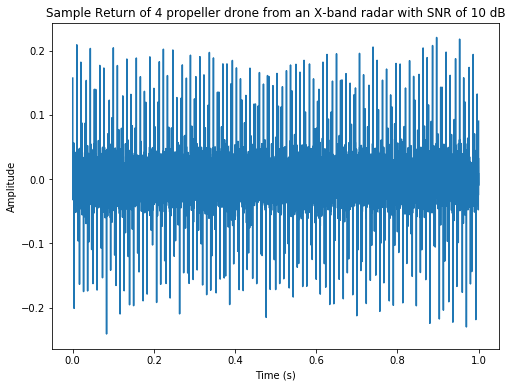

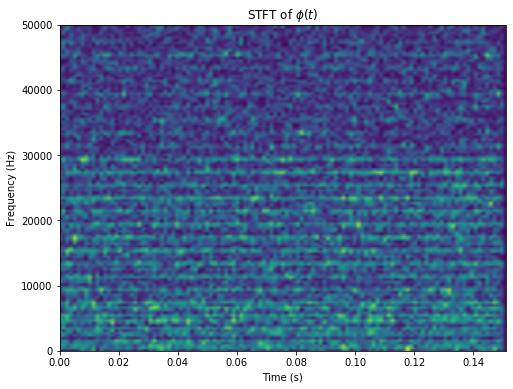

In [6]:
t, sample_return = radar_return(4, 0.1, 75, x_band_radar, 10, 0)

plt.plot(t, sample_return.real)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Sample Return of 4 propeller drone from an X-band radar with SNR of 10 dB")
plt.show()

f1, t1, Sxx1 = signal.stft(sample_return.real, fs, return_onesided=True)
plt.pcolormesh(t1, f1, np.abs(Sxx1), shading='gouraud')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("STFT of $\phi(t)$")
plt.show()

Here it is with 5 dB SNR:

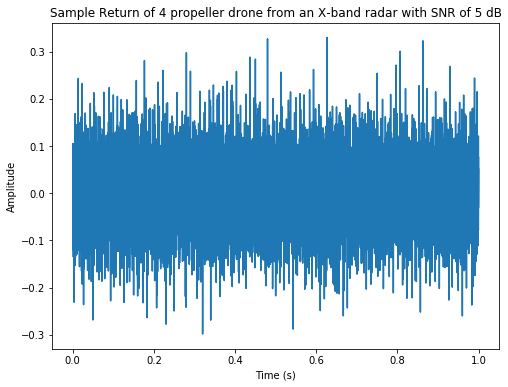

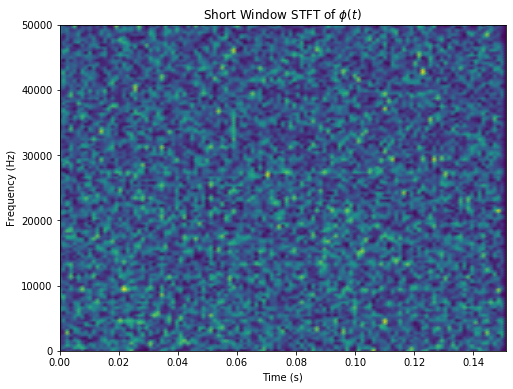

In [7]:
t, sample_return = radar_return(4, 0.1, 75, x_band_radar, 5, 0)

plt.plot(t, sample_return.real)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Sample Return of 4 propeller drone from an X-band radar with SNR of 5 dB")
plt.show()

f1, t1, Sxx1 = signal.stft(sample_return.real, fs, return_onesided=True)
plt.pcolormesh(t1, f1, np.abs(Sxx1), shading='gouraud')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Short Window STFT of $\phi(t)$")
plt.show()

## 3: Prepare Data Sets for application of ML techniques
Here, we will choose four different types of commercially available drones for simulation and verification, and we will generate simulated data sets for three different SNRs, such as 10, 5, and 0 dB, for both X-band and W-band radar.

First, we generate our drones:

In [8]:
drones = [{} for _ in range(4)]

drones[0]["N"] = 4
drones[0]["L2"] = 0.1
drones[0]["frot"] = 100

drones[1]["N"] = 2
drones[1]["L2"] = 0.1
drones[1]["frot"] = 180

drones[2]["N"] = 1
drones[2]["L2"] = 0.05
drones[2]["frot"] = 80

drones[3]["N"] = 6
drones[3]["L2"] = 0.12
drones[3]["frot"] = 100

We also will be testing the following SNRs: 10 dB, 5 dB, 0 dB

### Dataset 1: X-Band, 10 dB SNR

In [9]:
def build_dataset_1(N):
    #dataset_1 = np.array([[0, np.zeros(shape=(15000))] for _ in range(N * len(drones))], dtype='object')
    dataset_1 = []

    for i, drone in enumerate(drones):
        for j in range(N):
            time_offset = 100 * np.random.random_sample()
            
            dataset_1.append([0, radar_return(drone['N'], drone['L2'], drone['frot'], x_band_radar, 10, time_offset)[1].real])
    return np.array(dataset_1)

### Dataset 2: X-Band, 5 dB SNR

In [10]:
def build_dataset_2(N):
    #dataset_2 = np.array([[0, np.zeros(shape=(15000))] for _ in range(N * len(drones))], dtype='object')
    dataset_2 = []

    for i, drone in enumerate(drones):
        for j in range(N):
            time_offset = 100 * np.random.random_sample()
            
            dataset_2.append([1, radar_return(drone['N'], drone['L2'], drone['frot'], x_band_radar, 5, time_offset)[1].real])
    return np.array(dataset_2)

### Dataset 3: X-Band 0 dB SNR

In [11]:
def build_dataset_3(N):
    dataset_3 = []

    for i, drone in enumerate(drones):
        for j in range(N):
            time_offset = 100 * np.random.random_sample()
            
            dataset_3.append([2, radar_return(drone['N'], drone['L2'], drone['frot'], x_band_radar, 0, time_offset)[1].real])
    return np.array(dataset_3)

### Dataset 4: W-Band 10 dB SNR

In [12]:
def build_dataset_4(N):
    dataset_4 = []

    for i, drone in enumerate(drones):
        for j in range(N):
            time_offset = 100 * np.random.random_sample()
            
            dataset_4.append([3, radar_return(drone['N'], drone['L2'], drone['frot'], w_band_radar, 10, time_offset)[1][:15000].real])
    return np.array(dataset_4)

### Dataset 5: W-Band 5 dB SNR

In [13]:
def build_dataset_5(N):
    dataset_5 = []

    for i, drone in enumerate(drones):
        for j in range(N):
            time_offset = 100 * np.random.random_sample()
            
            dataset_5.append([4, radar_return(drone['N'], drone['L2'], drone['frot'], w_band_radar, 5, time_offset)[1][:15000].real])
    return np.array(dataset_5)

### Dataset 6: W-Band 0 dB SNR

In [14]:
def build_dataset_6(N):
    dataset_6 = []

    for i, drone in enumerate(drones):
        for j in range(N):
            time_offset = 100 * np.random.random_sample()
            
            dataset_6.append([5, radar_return(drone['N'], drone['L2'], drone['frot'], w_band_radar, 0, time_offset)[1][:15000].real])
    return np.array(dataset_6)

## 4: Apply Machine Learning Techniques to Identification of Drones

In this section, we will construct a convolutional neural network (CNN) to identify drones.

First, we apply the continuous wavelet transform (CWT) to each point in the dataset, then, we split the data into testing data and training data

In [15]:
def build_train_test(dataset):
    np.random.shuffle(dataset)
    labels, signals = map(list, zip(*dataset))
    #labels, signals = zip(*dataset)
    
    # Defining train and test data arrays
    train_size = int(0.8 * len(signals))
    test_size = len(signals) - train_size
    
    train_labels = labels[:train_size]
    test_labels = labels[train_size:]
    
    train_data_cwt = np.ndarray(shape=(train_size, 64, len(signals[0])))
    test_data_cwt  = np.ndarray(shape=(test_size, 64, len(signals[0])))
    
    # CWT params
    scales = range(64, 128)
    wavelet_name = 'morl'

    # Calculate CWT
    for i in range(train_size):
        signal = signals[i]
        coeff, _ = pywt.cwt(signal, scales, wavelet_name, 1)
        train_data_cwt[i, :, :] = coeff
        
    for i in range(train_size, train_size + test_size):
        signal = signals[i]
        coeff, _ = pywt.cwt(signal, scales, wavelet_name, 1)
        test_data_cwt[i - train_size, :, :] = coeff
    
    x_train = train_data_cwt
    y_train = train_labels
    
    x_test = test_data_cwt
    y_test = test_labels
    
    return x_train, y_train, x_test, y_test
    

Now that we are capable of building the data in the right format, we must now train a CNN.

In [16]:
import tensorflow as tf
import os
import datetime
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.callbacks import History

def train_model(x_train, y_train, x_test, y_test):
    history = History()
    
    input_shape = (64, 15000)
    
    num_classes = 6
    batch_size = 16
    epochs = 10
    
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    
    model = Sequential()
    model.add(Conv1D(32, kernel_size=5, strides=1,
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                 optimizer=keras.optimizers.Adam(),
                 metrics=['accuracy'])

    model.fit(x_train, y_train,
             batch_size=batch_size,
             epochs=epochs,
             verbose=1,
             validation_data=(x_test, y_test),
             callbacks=[history])
    
    train_score = model.evaluate(x_train, y_train, verbose=0)
    print(f"Train loss: {train_score[0]}, Train accuracy: {train_score[1]}")
    test_score = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test loss: {test_score[0]}, Test accuracy: {test_score[1]}")
    
    return model


Now, we generate datasets and models.

In [17]:
dataset_count = 20

dataset_1 = build_dataset_1(dataset_count)
dataset_2 = build_dataset_2(dataset_count)
dataset_3 = build_dataset_3(dataset_count)
dataset_4 = build_dataset_4(dataset_count)
dataset_5 = build_dataset_5(dataset_count)
dataset_6 = build_dataset_6(dataset_count)

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


In [18]:
x_train1, y_train1, x_test1, y_test1 = build_train_test(dataset_1)
print("1 Complete")
x_train2, y_train2, x_test2, y_test2 = build_train_test(dataset_2)
print("2 Complete")
x_train3, y_train3, x_test3, y_test3 = build_train_test(dataset_3)
print("3 Complete")
x_train4, y_train4, x_test4, y_test4 = build_train_test(dataset_4)
print("4 Complete")
x_train5, y_train5, x_test5, y_test5 = build_train_test(dataset_5)
print("5 Complete")
x_train6, y_train6, x_test6, y_test6 = build_train_test(dataset_6)
print("6 Complete")

1 Complete
2 Complete
3 Complete
4 Complete
5 Complete
6 Complete


In [19]:
def shuffle_together(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

In [20]:
x_train = np.concatenate([x_train1, x_train2, x_train3, x_train4, x_train5, x_train6])
y_train = np.concatenate([y_train1, y_train2, y_train3, y_train4, y_train5, y_train6])
x_test = np.concatenate([x_test1, x_test2, x_test3, x_test4, x_test5, x_test6])
y_test = np.concatenate([y_test1, y_test2, y_test3, y_test4, y_test5, y_test6])

x_train1 = None
x_train2 = None
x_train3 = None
x_train4 = None
x_train5 = None
x_train6 = None
x_test1 = None
x_test2 = None
x_test3 = None
x_test4 = None
x_test5 = None
x_test6 = None

In [21]:
shuffle_together(x_train, y_train)
shuffle_together(x_test, y_test)

### Training

In [22]:
model = train_model(x_train, y_train, x_test, y_test)

Epoch 1/10
24/24 [==============================] - 6s 235ms/step - loss: 1.9531 - accuracy: 0.1748 - val_loss: 1.5994 - val_accuracy: 0.2917
Epoch 2/10
24/24 [==============================] - 5s 210ms/step - loss: 1.3704 - accuracy: 0.4484 - val_loss: 1.8495 - val_accuracy: 0.3021
Epoch 3/10
24/24 [==============================] - 5s 211ms/step - loss: 0.9408 - accuracy: 0.7225 - val_loss: 1.6523 - val_accuracy: 0.4375
Epoch 4/10
24/24 [==============================] - 5s 207ms/step - loss: 0.7378 - accuracy: 0.7778 - val_loss: 1.9606 - val_accuracy: 0.3750
Epoch 5/10
24/24 [==============================] - 5s 206ms/step - loss: 0.5015 - accuracy: 0.8773 - val_loss: 2.2403 - val_accuracy: 0.4896
Epoch 6/10
24/24 [==============================] - 5s 207ms/step - loss: 0.5017 - accuracy: 0.8813 - val_loss: 2.7379 - val_accuracy: 0.4167
Epoch 7/10
24/24 [==============================] - 5s 206ms/step - loss: 0.6435 - accuracy: 0.8307 - val_loss: 3.4869 - val_accuracy: 0.3750
Epoch 

### Confusion Matrix

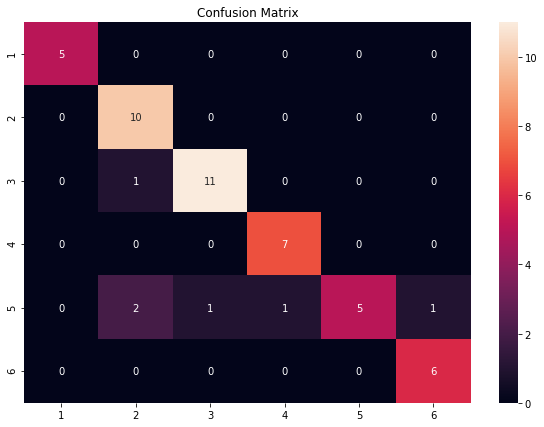

In [23]:
import seaborn as sn
import pandas as pd

test_idx = np.random.randint(len(x_train) + len(x_test), size=50)

test = np.concatenate([x_train, x_test])[test_idx, :]
test_labels = np.concatenate([y_train, y_test])[test_idx]

y_received = tf.argmax(model(test), 1).numpy()
confusion = tf.math.confusion_matrix(labels=test_labels, predictions=y_received, num_classes=6).numpy()

df_cm = pd.DataFrame(confusion, index = [i for i in "123456"],
                  columns = [i for i in "123456"])

plt.figure(figsize = (10,7))
plt.title("Confusion Matrix")
sn.heatmap(df_cm, annot=True)